## Project Premise
I've been contracted as a data scientist to look at recent data from a regional airline designing flight deals for young professionals flying their airline. They'd like a model that accurately predicts which customers are more likely to purchase travel insurance since previous research has shown those customers are most likely to buy flight deals of this type, so they'd like to use this model for subsequent customer targeting. 

## Project Setup

#### Import modules

In [1]:
import warnings
import seaborn as sns
import pylab as py
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import dtreeviz
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from skimpy import skim
from scipy.stats import shapiro
from scipy.stats import pointbiserialr
from scipy.stats import fisher_exact
from plotly.subplots import make_subplots
import plotly.io as pio

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import KFold,train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics

#### Import helper functions

In [3]:
from travel_insurance_functions import binary_formatter
from travel_insurance_functions import binary_grapher
from travel_insurance_functions import create_heatmap
from travel_insurance_functions import range_grapher
from travel_insurance_functions import make_subplot
from travel_insurance_functions import numerical_subplot
from travel_insurance_functions import calculate_log_model_stats
from travel_insurance_functions import create_contingency_table
from travel_insurance_functions import fishers_exact_test
from travel_insurance_functions import create_fishers_array
from travel_insurance_functions import create_confusion_matrix
from travel_insurance_functions import create_model_predictions
from travel_insurance_functions import calculate_model_statistics
from travel_insurance_functions import shapiro_wilk
from travel_insurance_functions import conduct_grid_search_tuning
from travel_insurance_functions import show_logistic_model_features
from travel_insurance_functions import consolidate_model_stats
from travel_insurance_functions import compare_models
from travel_insurance_functions import resplit_data
from travel_insurance_functions import calculate_v2_model_training_stats
from travel_insurance_functions import calculate_v2_model_testing_stats
from travel_insurance_functions import test_score_range
from travel_insurance_functions import assemble_performance_metrics_df
from travel_insurance_functions import limit_percentages
from travel_insurance_functions import test_score_range
from travel_insurance_functions import calculate_grid_search_ranges
from travel_insurance_functions import pull_rank_one_runs
from travel_insurance_functions import restrict_grid_search_table
from travel_insurance_functions import conduct_cross_validation

/Users/lemuelrobinson/Documents/Turing_College/Module_3/3_Sprint_1_Travel_Insurance/travel_insurance_functions.py:586: SyntaxWarning: invalid escape sequence '\d'


#### Other settings

In [4]:
os.chdir(
    "/Users/lemuelrobinson/Documents/Turing_College/Module_3/3_Sprint_1_Travel_Insurance"
)
warnings.filterwarnings("ignore")
# Set pandas display setting
pd.set_option("display.max_colwidth", None)

# Set some printing style parameters
palette = sns.color_palette("bright")

# color palette for binary variable graphs
binary_color_map = {0: "rgb(154, 211, 189)", 1: "rgb(58, 121, 136)"}

# Set default figure size
sns.set(rc={"figure.figsize": (14, 6)})

# Set significant figures for pandas printouts
pd.set_option("display.precision", 3)

# Specify scoring metrics for classifier models
scoring_metrics = ["accuracy", "precision", "recall", "f1"]

#Set default figure size
pio.templates.default = "plotly"
pio.templates["plotly"].layout.update(width=1200, height=750);

In [5]:
df = pd.read_csv("TravelInsurancePrediction.csv")
# Rename columns
df = df.rename(
    columns={
        "": "index",
        "Age": "age",
        "Employment Type": "employment",
        "GraduateOrNot": "college_grad",
        "AnnualIncome": "income",
        "FamilyMembers": "family_size",
        "ChronicDiseases": "conditions",
        "FrequentFlyer": "frequent_traveler",
        "EverTravelledAbroad": "first_trip",
        "TravelInsurance": "travel_insurance",
    }
)
# Drop unamed index column
df = df.iloc[:, 1:]
df

,age,employment,college_grad,income,family_size,conditions,frequent_traveler,first_trip,travel_insurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0
...,...,...,...,...,...,...,...,...,...
1982,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes,1
1983,28,Private Sector/Self Employed,Yes,1750000,5,1,No,Yes,0
1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0
1985,34,Private Sector/Self Employed,Yes,1000000,6,0,Yes,Yes,1


## Exploratory Data Analysis

Now that we've read in our dataset, We can see a mix of categorical and numerical variables, leaning harder on the categorical binary variables. Let' start by sense-checking our domains first.

In [6]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1987   │ │ int64       │ 5     │                                                          │
│ │ Number of columns │ 9      │ │ string      │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name       ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ age               │   0 │     0 │   29.65 │  2.913 │     25 │     28 │     29 │      32 │      35 │ ▃▇▂▃▃▅ │  │
│ │ income            │   0 │     0 │  932800 │ 376900 │ 300000 │ 600000 │ 900000 │ 1250000 │ 1800000 │ ▆▇▆▇▇▁ │  │
│ │ family_size       │   0 │     0 │   4.753 │   1.61 │      2 │      4 │      5 │       6 │       9 │ ▇▇▇▅▃▂ │  │
│ │ conditions        │   0 │     0 │  0.2778 │  0.448 │      0 │      0 │      0 │       1 │       1 │ ▇    ▃ │  │
│ │ travel_insurance  │   0 │     0 │  0.3573 │ 0.4793 │      0 │      0 │      0 │       1 │       1 │ ▇    ▅ │  │
│ └───────────────────┴─────┴───────┴─────────┴────────┴────────┴────────┴────────┴─────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ NA     ┃ NA %      ┃ words per row             ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ employment                        │      0 │         0 │                       2.7 │                  5391 │  │
│ │ college_grad                      │      0 │         0 │                         1 │                  1987 │  │
│ │ frequent_traveler                 │      0 │         0 │                         1 │                  1987 │  │
│ │ first_trip                        │      0 │         0 │                         1 │                  1987 │  │
│ └───────────────────────────────────┴────────┴───────────┴───────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Our income range of 300,000-1,800,000 INR is per annum. According to one measure, 383,000 INR is the average annual income in 2024. According to the most recent World Bank data, the country had a Gini coefficient of 32.8, which is fairly high. This level of inequality means that there will be people within the country making significantly more and significantly less than this number, and therefore this range could be considered reasonable depending on how we'd like to use our analysis. <br><br> Ages are a pretty tight band at 25-34, with family sizes ranging from 2-9 people. Taken together, these three variables suggest that demographically speaking, our dataset comprises young professionals that are traveling either with their partners, their children, or other family members. <br><br>Now that we know more about the general domain of our features, let's check for null values. 

### Checking for null values

In [7]:
df.isnull().sum()

age                  0
employment           0
college_grad         0
income               0
family_size          0
conditions           0
frequent_traveler    0
first_trip           0
travel_insurance     0
dtype: int64

We don't have any null values in this dataset, which is pretty convenient, we can of course keep an eye out for null values being coded as -1 or '' or some other way as we continue. Let's let's check for balance across the features in our dataset since that might also be a necessary detail for our modeling later. 

### Feature Exploration

#### Categorical/Binary features

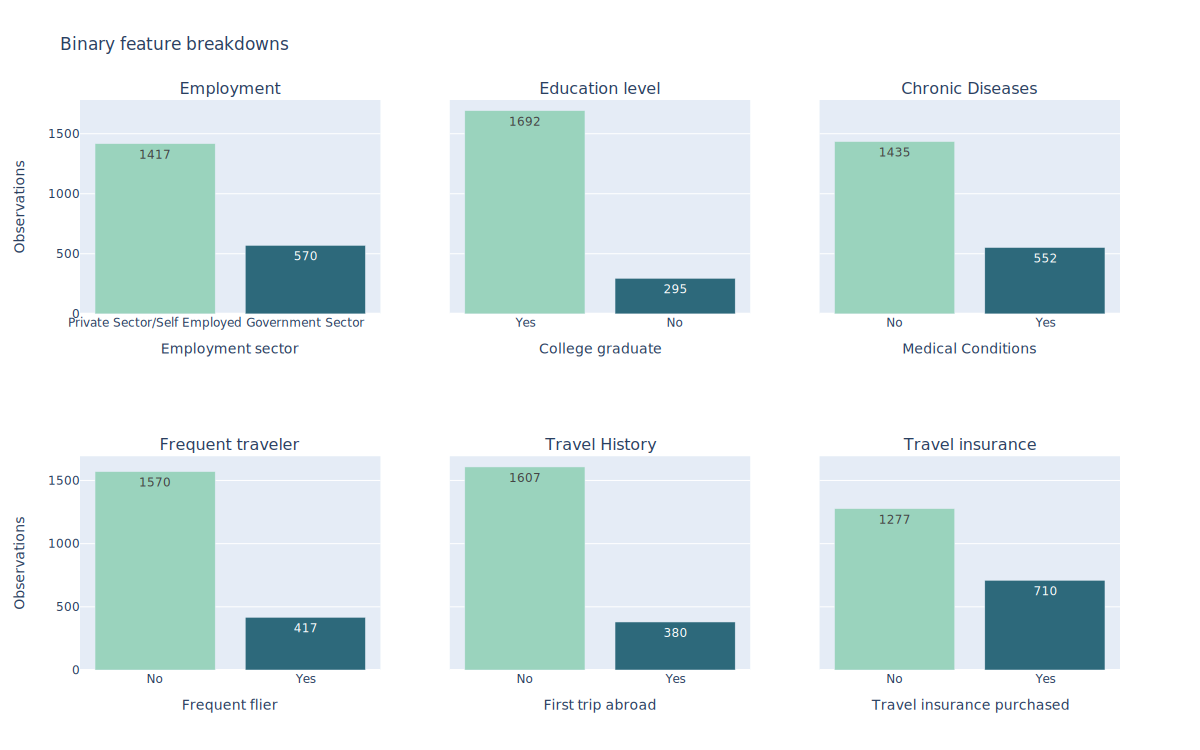

In [56]:
# Format all features as yes/no strings wherever they are in 0/1 format
df = binary_formatter(df, "string")

# Plot binary features
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=(
        "Employment",
        "Education level",
        "Chronic Diseases",
        "Frequent traveler",
        "Travel History",
        "Travel insurance",
    ),
    shared_yaxes=True,
)
make_subplot(df,fig, "employment", [1, 1])
make_subplot(df,fig, "college_grad", [1, 2])
make_subplot(df,fig, "conditions", [1, 3])
make_subplot(df,fig, "frequent_traveler", [2, 1])
make_subplot(df,fig, "first_trip", [2, 2])
make_subplot(df,fig, "travel_insurance", [2, 3])


# Update xaxis properties
fig.update_xaxes(title_text="Employment sector", row=1, col=1)
fig.update_xaxes(title_text="College graduate", row=1, col=2)
fig.update_xaxes(title_text="Medical Conditions", row=1, col=3)
fig.update_xaxes(title_text="Frequent flier", row=2, col=1)
fig.update_xaxes(title_text="First trip abroad", row=2, col=2)
fig.update_xaxes(title_text="Travel insurance purchased", row=2, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Observations", row=1, col=1)
fig.update_yaxes(title_text="Observations", row=2, col=1)


# Update title and height
fig.update_layout(title_text="Binary feature breakdowns", showlegend=False)

# Display plot
fig.show('svg')

These plots show that none of our categorical features have balanced observations across classes. We can stratify on travel insurance when we do our training and testing data splits later so that the classification models see equal numbers of each outcome, but we might have to select metrics and methods to counteract the lopsidedness we see in our X matrix here. Let's see how things look on the numerical features side. 

#### Numerical features

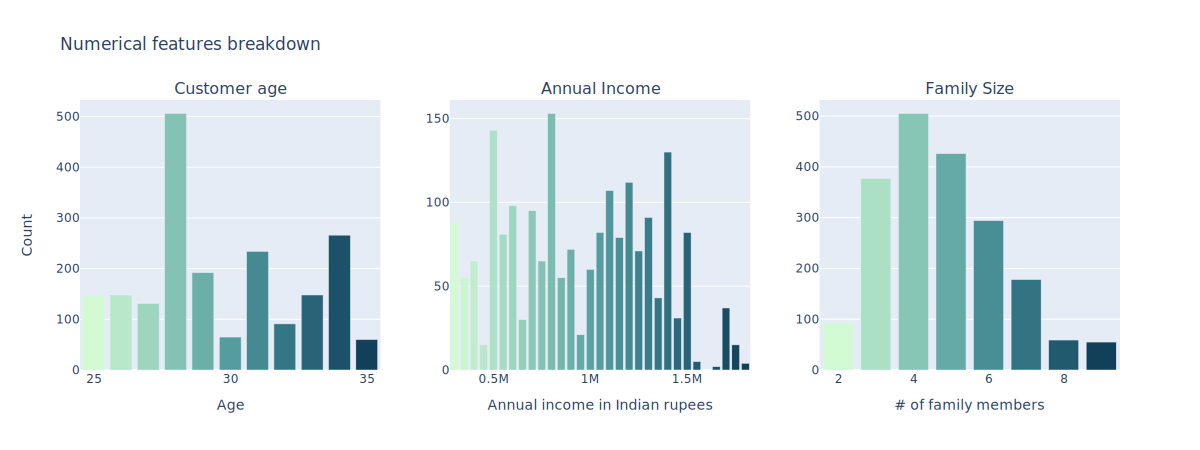

In [55]:
# Create subplots figure
fig2 = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=("Customer age", "Annual Income", "Family Size"),
)

# Plot 3 variables in their respective subplots
numerical_subplot(df,fig2, "age", [1, 1])
numerical_subplot(df,fig2, "income", [1, 2])
numerical_subplot(df,fig2, "family_size", [1, 3])

# Set x axis for each
fig2.update_xaxes(title_text="Age", row=1, col=1)
fig2.update_xaxes(title_text="Annual income in Indian rupees", row=1, col=2)
fig2.update_xaxes(title_text="# of family members", row=1, col=3)

# Update yaxis properties
fig2.update_yaxes(title_text="Count", row=1, col=1)
fig2.update_yaxes(title_text="Count", row=2, col=1)

# Adjust title and adjust figure height
fig2.update_layout(
    title_text="Numerical features breakdown", height=450, showlegend=False
)
fig2.show('svg')

As stated earlier our ages range from 25-35, with a large number of them being 28. Family size does take on a bell curve shape centered at 4-5 family members.  Annual income takes on a fairly wide range, but doesn't appear to be normally distributed even though it could converge to a more normal shape if our dataset were larger. We have a graphical representation of the data, but let's test the assumption that our incomes come from a normal distribution more rigorously. Doing so will help us get a sense of how representative of the general population of Indian workers in this age range our data is, because that could have implications for our travel deal products later on. We'll use the Shapiro-Wilk test for normality. 

#### Testing for Normality

$H_0$ = data comes from a normal distribution<br>
$H_1$ = data does not come from a normal distribution

Now that we've established our hypotheses for this test, let's scale and run the hypothesis test. Though our income data is encoded as discrete rupee quantities, it should be possible to be paid in fractional rupee amounts, so we'll use standard scaling to place the data points along a continuous distribution before running Shapiro-Wilk.

In [10]:
# Copy income as a dataframe
income = pd.DataFrame(df["income"].copy())

# Create standard scaler instance
scaler = StandardScaler()

# Scale income
income_scaled = pd.Series(scaler.fit_transform(income).reshape(-1))

# Conduct shapiro-wilk test for normality
shapiro_wilk(income_scaled)

,None,values
0,SP-test statistic,0.965
1,p-value,0.000


Our p-value from this test is vanishingly small, so we have sufficient evidence to reject the null hypothesis and conclude that our income data is in fact not normally distributed. This reinforces the idea that our consumer base is distinct from the general population along this dimension, which we'll keep in mind as we continue our analysis. 

### Correlation across features

Considering our mix of categorical and numerical variables, we'll have to consider correlations from a number of angles. In this section, we'll use Fisher's Exact test for categorical-categorical comparison, with Point-Biserial Correlation being our method for binary and numerical variable comparison. Let's first isolate a dataframe of just our binary variables. 

In [11]:
# Format all binary variables as 1/0
binary_df = binary_formatter(df, "binary")

# Drop non-binary variables
binary_df = binary_df[
    [
        "college_grad",
        "conditions",
        "frequent_traveler",
        "first_trip",
        "travel_insurance",
    ]
]

#### Point-Biserial Correlations

Point-biserial correlations are a specific type of correlation used to measure the relationship between a binary variable and a continuous variable, and are mathematically equivalent to the Pearson correlation used more commonly.  The correlation statistic is calculated as follows: 

\begin{align}
r_{pb} = \frac{M_1-M_0}{s_n}\sqrt\frac{n_1 \cdot n_0}{n^2}
\end{align}

Where:
- M1 is the mean of the continuous variable for one class of the binary variable
- M0 is the mean of the continuous variable for the other class of the binary variable 
- s is the standard deviation of the continuous variable
- p is the proportion of cases in one group of the binary variable

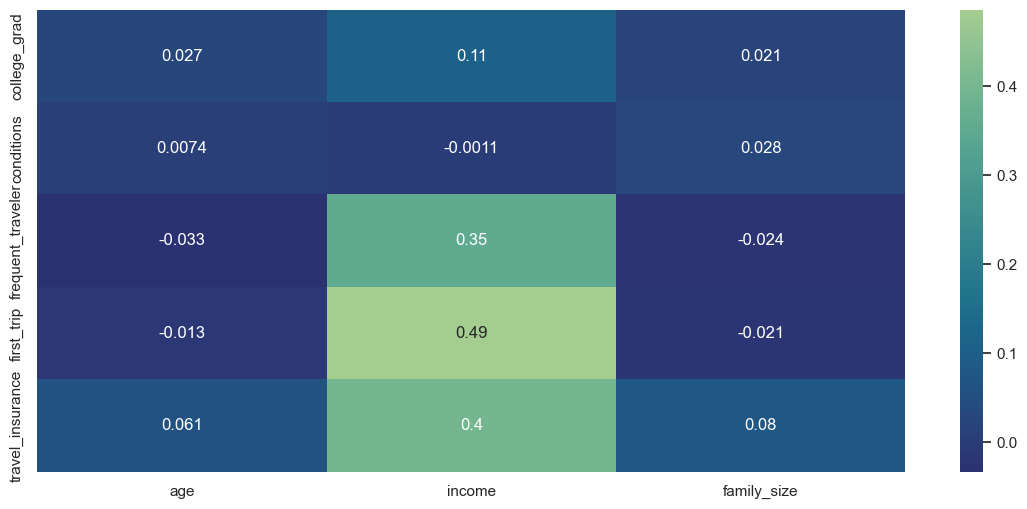

In [12]:
# Create dataframe for this correlation set
continuous_variables = ["age", "income", "family_size"]
array = np.zeros((len(binary_df.columns), len(continuous_variables)), dtype=int)
pb_corr_df = pd.DataFrame(data=array, columns=continuous_variables).set_index(
    binary_df.columns
)

# Calculate correlations and overwrite dataframe
for col in pb_corr_df.columns:
    pb_corr_df[col] = [
        pointbiserialr(df[col], binary_df[x])[0] for x in binary_df.columns
    ]

# Show heatmap of correlations
create_heatmap(pb_corr_df)

From our heatmap we can see that our highest correlations are moderate, between income and travel_insurance, first_trip, and frequent_traveler features, which makes sense. Higher-income earners are more likely to travel frequently, however there are two potentially surprising correlations here. 

Income and first trip being suggested might point to a significant number of high-earners reaching a new level of wealth or status, and thus taking their first trip. This may mean that a signficant proportion of our dataset is comprised of new, higher-earning travelers, which behave differently than established, previously wealthy travelers when it comes to booking travel packages and interacting with airline rewards or deals. Income and travel_insurance being correlated suggests that higher income earners are more likely to purchase travel insurance, which could point to either their sentiments or trust toward airlines, or it could suggest that high earners on their first trip are more likely to buy travel insurance to protect their flight experience. 

We should take a closer look at the correlation between travel_insurance and first_trip to get a clearer picture. Let's move on to Fisher's Exact test to examine this and other potential correlations. 

#### Fisher's Exact Test


We'll use Fisher's Exact Test to check for correlations between binary variables. More precisely, this test checks for non-random associations between pairs of categorical variables. The null and alternate hypotheses for this test go as follows: 

$H_0$ = The two categorical variables are independent. 
<br>$H_1$ = There is an association between the two categorical variables, i.e. they are not independent.
<br>$\alpha$ = 0.05

For each pair of variables, this test calculates the probabilities for all permutations of observations in the 2X2 contingency table between variables and assigns p-values to those variables based on the assumption that $H_0$ is true. The following table is a heatmap of those p-values, with lower values meaning a higher likelihood of dependence between the variables.  

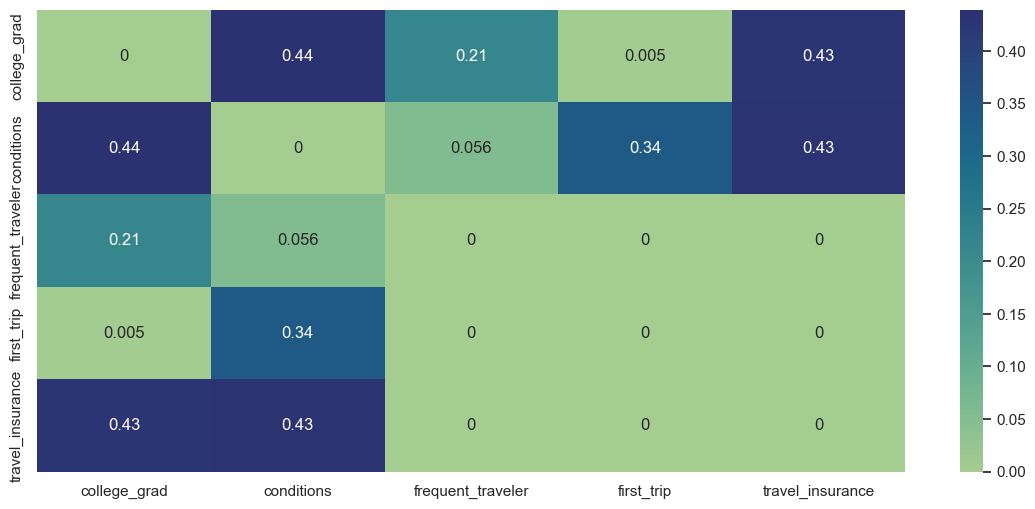

In [13]:
fishers_p_values = create_fishers_array(binary_df)
heatmap = create_heatmap(fishers_p_values, reversed=False)

In this heatmap, the squares of note are all pistachio green, with the the most notable being p-values equal to zero that do not lie on the diagonal. First_trip and travel insurance are indeed correlated, as are college_grad and first_trip. First_trip and frequent_traveler are understandably correlated because by construction they cannot be true at the same time. Now that we've taken the time to understand our 9 variables within the dataset, let's preprocess our data so that we can get to modeling. 

### Feature Engineering/ Cleaning

Let's clone our dataset, encoding employment as a categorical feature to match the others. Additionally we'll scale the data. 

In [14]:
# Before we make any changes, let's copy df so that we can make changes to it to prep for modeling
model_df = df.copy()

# Next let's encode employment as a binary variable
model_df.employment = LabelEncoder().fit_transform(model_df["employment"])

model_df = pd.DataFrame(
    MinMaxScaler().fit_transform(model_df), columns=model_df.columns
)

Now let's split the data into testing and training sets.

In [15]:
# Keep an overall X and y to use later
X = model_df.drop(columns="travel_insurance")
Y = model_df["travel_insurance"]

# Split the set into training and testing data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1, stratify=Y
)

In [16]:
# Before we continue let's check if stratification worked as intended 
y_strat=pd.concat([y_train.value_counts(),y_test.value_counts()],axis=1)
y_strat.columns=['y_train','y_test']
y_strat['training_proportion']=y_strat.y_train/(y_strat.y_train+y_strat.y_test)
y_strat['testing_proportion']=y_strat.y_test/(y_strat.y_train+y_strat.y_test)
y_strat


,y_train,y_test,training_proportion,testing_proportion
travel_insurance,,,,
0.0,893,384,0.699,0.301
1.0,497,213,0.700,0.300


Our stratify parameter in train_test_split worked as intended, balancing y-classes across training and testing sets, so we're good to go. Let's model. 

# Predictive modeling

Now that we've prepped our data, we can discuss our model setup. We'll use the following 4 models:
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Naive Bayes

For each, we'll conduct hyperparameter tuning for the model of interest, proceeding to cross-validation, and then to finally running the model on the test_set for validation. Each model will be assessed on accuracy and precision for their performance at classifying our data, but we will also calculate recall and f1-scores to have have a more complete picture of our classification at each step of the process. 

Once we've completed this process for each of these models, we'll take step of which models seem to be better for our data, before exploring options for ensemble models. 

## Logistic Regression

We'll start with this model because it's one of the most widely used supervised model types, is pretty simple to interpret, and also is computationally efficient. Since there are many hyperparameter setups that we could end up with, we should start with tuning before we dive into model building. 

### Hyperparameter tuning

We'll use grid search to find the best performing model setup, based on the available options for solvers and for penalty. We'll use different values for C to test different regularizations of our models, different penalty settings, and different solvers. 

In [17]:
# Specify the different options for hyperparameters
grid = {
    "C": np.logspace(-3, 3, 25),
    "penalty": ["l1", "l2"],
    "solver": ["lbfgs", "sag", "saga", "newton-cg", "liblinear"],
}

# Initialize model
logr = LogisticRegression()

# Conduct gridsearch
logr_cv = GridSearchCV(logr, grid, cv=10)
logr_cv.fit(x_train, y_train)
logr_gridsearch_params = logr_cv.best_params_

print("Best performing parameters ", logr_cv.best_params_)
print("Model accuracy :", np.round(logr_cv.best_score_, 4))

Best performing parameters  {'C': 0.1778279410038923, 'penalty': 'l1', 'solver': 'liblinear'}
Model accuracy : 0.7712


Within grid search, these hyperparameters provided the more accurate model predictions. Now we'll cross validate this model and see how it performs along other metrics before testing it on our test set. 

### Cross-validation

In [18]:
# Initialize lists
means = []
stds = []
intervals = []
solvers = []
metrics = []
penalties = []

# Create kfold instnace for cross_validation
kfold = KFold(n_splits=10)

# Save the tuned model parameters so that we can recreate it later
tuned_logistic_model = LogisticRegression(
    C=logr_gridsearch_params["C"],
    penalty=logr_gridsearch_params["penalty"],
    solver=logr_gridsearch_params["solver"],
)

# Create new log_model from gridsearch specifications
log_model_v1 = tuned_logistic_model

# Create vector of evaluation scores
for metric in scoring_metrics:
    cv_vector = cross_val_score(
        estimator=log_model_v1, X=x_train, y=y_train, cv=kfold, scoring=metric
    )
    # Calculate mean and standard deviation for vectors
    cv_mean = cv_vector.mean()
    cv_std = cv_vector.std()

    # Update lists
    means.append(cv_mean)
    stds.append(cv_std)
    intervals.append([(cv_mean - cv_std).round(3), (cv_mean + 1.96 * cv_std).round(3)])
    metrics.append(metric)

logit_scores = pd.DataFrame(
    data={
        "statistic": metrics,
        "mean": means,
        "std_deviation": stds,
        "confidence_interval": limit_percentages(intervals),
    },
    index=scoring_metrics,
)
logit_scores

,statistic,mean,std_deviation,confidence_interval
accuracy,accuracy,0.768,0.035,"[0.733, 0.835]"
precision,precision,0.797,0.071,"[0.727, 0.936]"
recall,recall,0.471,0.061,"[0.41, 0.591]"
f1,f1,0.590,0.059,"[0.532, 0.705]"


Our tuned model performed pretty well. Now that we can see how our v1 model did in cross-validation, let's reshuffle the data, initialize a new model with our specifications, and then run the model on both training and test sets for validation. 

### Model Training and Testing

In [19]:
# Initialize a new model with the grid search parameters
logr_model_v2 = tuned_logistic_model

# Resplit data and fit model
x_train, x_test, y_train, y_test = resplit_data(X, Y)
logr_model_v2.fit(x_train, y_train);

In [20]:
# Calculate the predictions
training_predictions = logr_model_v2.predict(x_train)
testing_predictions = logr_model_v2.predict(x_test)

# Calculate model performances
v2_train = calculate_model_statistics(
    confusion_matrix(y_train, training_predictions), "v2:logr_training"
)
v2_test = calculate_model_statistics(
    confusion_matrix(y_test, testing_predictions), "v2:logr_testing"
)

# Consolidate model performances
logr_performance_metrics = pd.concat(
    [logit_scores.iloc[:, 1], v2_train, v2_test], axis=1
).rename(columns={"mean": "logr_cv"})
logr_performance_metrics

,logr_cv,v2:logr_training,v2:logr_testing
accuracy,0.768,0.782,0.749
precision,0.797,0.813,0.752
recall,0.471,0.507,0.441
f1,0.590,0.625,0.556


Here we can see that our model is performing pretty consistently, sometimes even outperforming itself when testing data is introduced, so we don't have to worry about overfitting this time. 
As a final check, let's see if we can boost the efficacy of this model even more by passing our dataset through the KBest algorithm to select only the most influential features for predicting travel_insurance. We've tuned the hyperparameters for the model, but not yet verified our features. 

We'll create a pipeline to run through all numbers k in our dataset range, and then use grid search to find the optimal number of features k for our model. 

In [21]:
# Initialize kbest
kbest = SelectKBest(score_func=mutual_info_classif)

# Define our k-features possibilities
param = {"kbest__k": list(range(9))}

# Initialize a new model
logr_test = tuned_logistic_model

# Create a pipeline  for kbest and logistic regression
pipe = Pipeline([("kbest", kbest), ("v3", logr_test)])

# Pass the pipeline to Grid search
model = GridSearchCV(pipe, param_grid=param, cv=10)
model.fit(x_train, y_train)

# Let's save our best performing k as a variable
k = model.best_params_["kbest__k"]

# Get the best estimator from the grid search
best_model = model.best_estimator_

# Get the SelectKBest step from the pipeline
select_step = best_model.named_steps['kbest']

# Get the indices of the selected features
selected_feature_indices = select_step.get_support(indices=True)

# Get the feature names from the original X_train DataFrame
kbest_features = x_train.columns[selected_feature_indices].tolist()

print(f"The best performing model has {k} features.")

The best performing model has 5 features.


Now that we've arrived our best performing model, let's fit a v3 version of our model using SelectKBest's chosen features to size how much more efficiency we get from this change.  

In [22]:
# Limit features to the kbest output
v3_columns = kbest_features
v3_xtrain = x_train[v3_columns]
v3_xtest = x_test[v3_columns]

# Let's fit a logistic model from this set
logr_v3_model = tuned_logistic_model
logr_v3_model.fit(v3_xtrain, y_train);

Now let's rerun our statistics using cross-validation, overall training_set, and then test-set to see how this more limited v3 model stacks up. 

In [23]:
# Calculate predictions for training and test sets
train_predictions = logr_v3_model.predict(v3_xtrain)
test_predictions = logr_v3_model.predict(v3_xtest)

# put this into a dataframe
logr_performance_metrics["v3: kbest_train"] = calculate_log_model_stats(
    y_train, train_predictions
)
logr_performance_metrics["v3: kbest_test"] = calculate_log_model_stats(
    y_test, test_predictions
)
logr_performance_metrics

,logr_cv,v2:logr_training,v2:logr_testing,v3: kbest_train,v3: kbest_test
accuracy,0.768,0.782,0.749,0.763,0.729
precision,0.797,0.813,0.752,0.799,0.722
recall,0.471,0.507,0.441,0.449,0.390
f1,0.590,0.625,0.556,0.575,0.506


From cross-validation to our v2 model we can see modest increases in our decently high accuracy. However, once we used the SelectKBest algorithm to restrict our features, we saw reductions on our model effectiveness. Considering how small our dataset is, and how few features we have, we appear to be hitting diminishing returns. Therefore, we can confidently say that our final model is the v2 model we fitted above. Let's display those coefficients here. 

In [24]:
coefs = logr_model_v2.coef_[0]
logr_coefficients = pd.DataFrame(data={"coefficients": coefs}, index=kbest_features)
logr_coefficients["odds_increase"] = logr_coefficients.coefficients.apply(
    lambda x: np.exp(x)
)
logr_coefficients

,coefficients,odds_increase
age,0.295,1.343
income,2.026,7.584
family_size,0.442,1.556
conditions,-0.031,0.969
first_trip,1.709,5.525


For each variable here, the coefficient represents the impact to log-odds of quality_rating. The third colummn calculates the impact on the odds of a airline customer purchasing travel insurance when that variable increases by one unit, assuming all other variables are held constant.

## K - Nearest Neighbors

Moving to KNN, we'll once again with a grid search across hyperparameters of interest for KNN classifiers. This model could come in handy since it is flexible and is simple to understand. Also, it's non-parametric, so it won't be less effective if our assumptions about linearity the distribution of the data do not hold. Let's first define our hyperparameter grid.

In [25]:
# Specify test space for grid search
knn_grid = {
    "n_neighbors": range(0, 50),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

# Conduct grid search on knn model
knn_best_params, knn_cv_accuracy = conduct_grid_search_tuning(
    "knn", knn_grid, x_train, y_train
)
print(knn_best_params)

# Save our tuned KNN as a variable
tuned_knn = KNeighborsClassifier(
    algorithm=knn_best_params["algorithm"],
    n_neighbors=knn_best_params["n_neighbors"],
    weights=knn_best_params["weights"],
)
# Initialize a knn instance
knn_cross_val = tuned_knn

{'algorithm': 'brute', 'n_neighbors': 30, 'weights': 'uniform'}


### Cross-validation

Now that we have a fitted model, let's assess our model along our performance metrics with cross-validation.

In [26]:
knn_cv = conduct_cross_validation(knn_cross_val,x_train,y_train)
knn_cv

,mean_score,standard_deviation,confidence_interval
accuracy,0.796,0.027,"[0.769, 0.822]"
precision,0.837,0.025,"[0.812, 0.862]"
recall,0.529,0.061,"[0.468, 0.591]"
f1,0.647,0.049,"[0.598, 0.695]"


Our performance here is pretty strong for a first model, especially in terms of precision. Let's create a model trained on our training set and compare them before validating on the test_set as well. 

### Model Training and Testing

In [27]:
# Resplit data
x_train, x_test, y_train, y_test = resplit_data(X, Y)

# Create a knn model from our optimal grid search parameters
knn = tuned_knn

# Fit model, show parameters
knn.fit(x_train, y_train)

# Calculate training set stats for knn_v2
knn_train_perf = calculate_v2_model_training_stats(knn, x_train, y_train)

# Calculate test set stats for knn_v2
knn_test_perf = calculate_v2_model_testing_stats(knn, x_test, y_test)

# Assemble dataframe across models
knn_performance_metrics = assemble_performance_metrics_df(
    knn_cv, knn_train_perf, knn_test_perf
)
knn_performance_metrics

,v1: cross_val,v2: training,v2: testing
accuracy,0.796,0.771,0.797
precision,0.837,0.820,0.865
recall,0.529,0.459,0.512
f1,0.647,0.588,0.643


Our v2 model is doing well compared to the cross-validation model. We've lost some precision, but have made gains in accuracy and recall. With the introduction of the test set, it looks like we have a reduction in accuracy, suggesting some slight overfitting to the training data. Considering how small our feature set is, these models are running pretty fast. We probably don't need need to worry about the curse of dimensionality here, and we don't have a terrible case of overfitting. Let's pause making further improvements here and look at decision trees. 

## Decision Trees

This model is easy to visualize and interpret, and we can also control how deep we want the tree to go, or prune it back if we identify any overfitting.

### Hyperparameter Tuning

In [28]:
dt_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": list(range(1, 11)),
}
# Grid search and save parameters
dt_best_params, dt_cv_accuracy = conduct_grid_search_tuning("decision_tree", dt_grid,x_train,y_train)
tuned_dt = DecisionTreeClassifier(
    criterion=dt_best_params["criterion"],
    max_depth=dt_best_params["max_depth"],
    splitter=dt_best_params["splitter"],
    random_state=1,
)

### Cross-validation
Now that we have defined optimal model parameters, let's create a decision tree for cross-validation. 

In [29]:
# Create a decision tree instance for cross_validation
dt_v1 = tuned_dt

# Run cross validation for the DT model
dt_cv = conduct_cross_validation(dt_v1,x_train,y_train)
dt_cv

,mean_score,standard_deviation,confidence_interval
accuracy,0.825,0.035,"[0.79, 0.86]"
precision,0.913,0.044,"[0.868, 0.957]"
recall,0.570,0.060,"[0.509, 0.63]"
f1,0.699,0.047,"[0.652, 0.746]"


The starting performance for this model is already higher than the first two that we've seen so far, which could be interesting for our analysis, let's continue training and testing to dive deeper.

### Model Training and Testing

In [30]:
# Resplit data before creating model_v2
x_train, x_test, y_train, y_test = resplit_data(X, Y)

# Create v2 decision tree
dt_v2 = tuned_dt

# Fit model
dt_v2.fit(x_train, y_train)

# Calculate training and testing statistics
dt_train = calculate_v2_model_training_stats(dt_v2, x_train, y_train)
dt_test = calculate_v2_model_testing_stats(dt_v2, x_test, y_test)

dt_performance_metrics = assemble_performance_metrics_df(dt_cv, dt_train, dt_test)
dt_performance_metrics

,v1: cross_val,v2: training,v2: testing
accuracy,0.825,0.841,0.824
precision,0.913,0.918,0.943
recall,0.570,0.610,0.540
f1,0.699,0.733,0.687


This model is working consistently well so far. Let's visualize this tree to take a closer look at the layers.

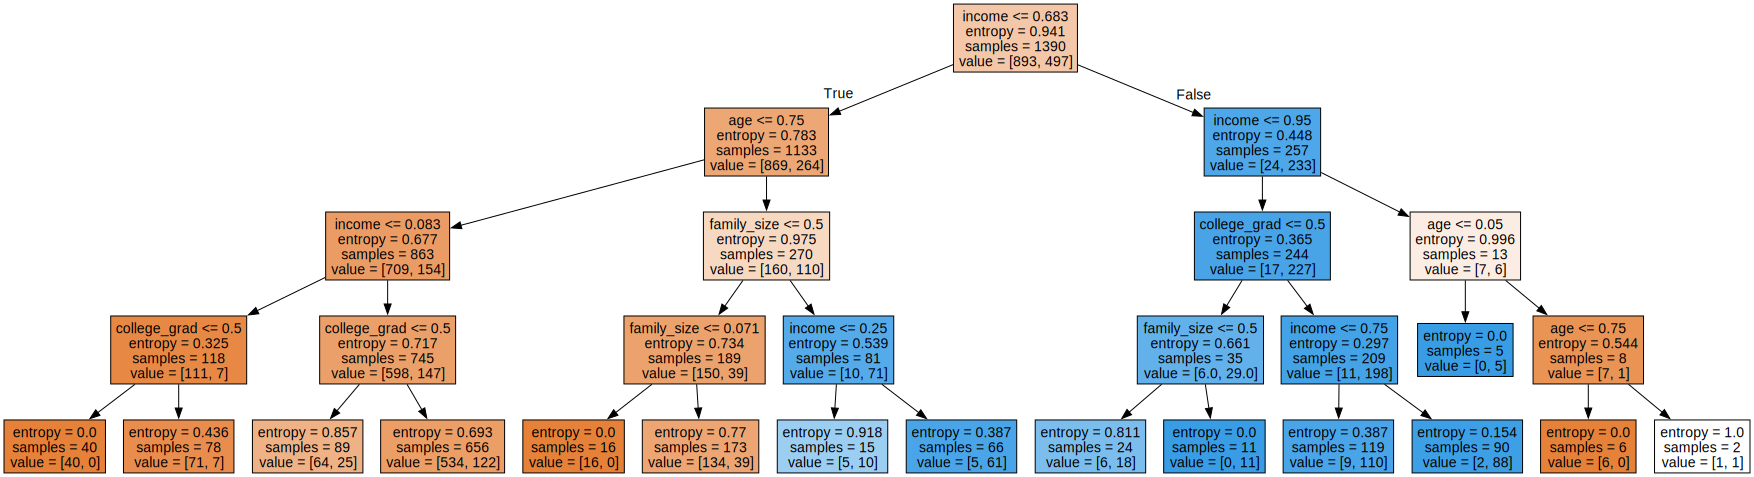

In [31]:
dot_data = tree.export_graphviz(
    dt_v2, out_file=None, feature_names=x_train.columns, filled=True
)
graphviz.Source(dot_data, format="png")

In this decision tree diagram the colors represent the entropy of that node, with light colors being more equal in terms of balance between label classes, and the warmer/cooler colors corresponding to the label class that is more prevalent at that decision boundary. The main takeaway here is that we were about to get a reasonably strong model without having a really complex decision tree, which performed decently well across both training and testing sets.

## Naive Bayes


From our correlations during the EDA phase of the project we know that the naive assumption of independence doesn't hold for our data, but NB classifiers still might prove useful since they are robust to the presence of non-essential features, and not too intensive in terms of calculations. Since our CategoricalNB Naive Bayes classifier works best with categorical data, we're going to use binning to discretize our income and age features into categorical groupings.

In [32]:
# Copy model_df
nb_df = model_df.copy()

# Transform the continuous features
income_bins = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform")
nb_df["income_binned"] = income_bins.fit_transform(nb_df[["income"]])
nb_df["age_binned"] = income_bins.fit_transform(nb_df[["age"]])

# Drop unbinned columns
nb_df.drop(columns=["age", "income"], inplace=True)

Now that we have our features binned we can resplit our data and proceed to tune our hyperparameters.

In [33]:
# Define X and Y
NBX = nb_df.drop(columns="travel_insurance") #Denote all binned x and y with NB prefix
NBY = nb_df.travel_insurance

# Split the set into training and testing data
nbx_train, nbx_test, nby_train, nby_test = train_test_split(
    NBX, NBY, test_size=0.3, random_state=24, stratify=nb_df["travel_insurance"]
)

### Hyperparameter tuning

In [34]:
nb_grid = {"alpha": np.linspace(0, 10, num=100), "fit_prior": [True, False]}
nb_params, nb_accuracy = conduct_grid_search_tuning("nb", nb_grid, nbx_train, nby_train)
print(nb_params)

# Save tuned NB classifier settings
tuned_NB = CategoricalNB(alpha=nb_params["alpha"], fit_prior=nb_params["fit_prior"])

{'alpha': 10.0, 'fit_prior': True}


### Cross-validation

In [35]:
# Create nb classifier instance with default settings
nb_v1 = tuned_NB

#Fit model
nb_v1.fit(nbx_train, nby_train)

# Run cross validation for the DT model
nb_cv = conduct_cross_validation(nb_v1,nbx_train,nby_train)
nb_cv

,mean_score,standard_deviation,confidence_interval
accuracy,0.779,0.025,"[0.754, 0.804]"
precision,0.823,0.073,"[0.75, 0.896]"
recall,0.494,0.053,"[0.441, 0.548]"
f1,0.614,0.040,"[0.574, 0.654]"


Accuracy and precision are in the 70s for this model, which makes sense given that our data doesn't really fit the naive assumption of full independence among the x variables. Let's take a look at the training and test sets still just so we can assess this one on equal footing with the models we've seen so far. 

In [36]:
#Resplit data
nbx_train, nbx_test, nby_train, nby_test = resplit_data(NBX,NBY)

# Create a new classifier
nb_v2 = tuned_NB

# Fit model
nb_v2.fit(nbx_train, nby_train)

# Calculate statistics
nbv2_train=calculate_v2_model_training_stats(nb_v2,nbx_train,nby_train)
nbv2_test=calculate_v2_model_testing_stats(nb_v2,nbx_test,nby_test)

# Create new dt performance metrics df
nb_performance_metrics = assemble_performance_metrics_df(nb_cv,nbv2_train,nbv2_test)
nb_performance_metrics

,v1: cross_val,v2: training,v2: testing
accuracy,0.779,0.763,0.779
precision,0.823,0.774,0.814
recall,0.494,0.475,0.493
f1,0.614,0.589,0.614


This isn't the best model that we've seen so far, but it isn't particularly bad either. In the next section we'll get into ensembling, but before we do that we should take stock of our model performance against the ones that we've seen so far. Let's v2 model training performances so that we can assess them side-by-side. 

In [37]:
models = [
    logr_performance_metrics,
    knn_performance_metrics,
    dt_performance_metrics,
    nb_performance_metrics,
]

# Pull stats from all cross-validation models so far
single_models_df = consolidate_model_stats(models)
single_models_df

,logistic_regression,k_nearest_neighbors,decision_tree,naive_bayes
accuracy,0.782,0.771,0.841,0.763
precision,0.813,0.820,0.918,0.774
recall,0.507,0.459,0.610,0.475
f1,0.625,0.588,0.733,0.589


The Decision tree classifier is our strongest model so far, followed by Knn. The logistic regression was our most iterated model, but scores the lowest on accuracy and precision. In the next section we'll explore ensemble models since they could provide some modest boosts to accuracy, and we can use takeaways from this table to try out different iterations of ensembling now that we have a baseline view of how these models look when fitted to our data in isolation. Let's start with a random forest so that we can compare it to our single decision tree model here. 

# Ensemble Models
## Random Forest

### Hyperparameter tuning

In [38]:
# Define grid of hyperparameters
RF_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": list(range(1, 11)),
    "max_features": ["sqrt", "log2", None],
}

# Resplit data
x_train, x_test, y_train, y_test = resplit_data(X, Y)

# Conduct grid search on random forest model
rf_best_params, rf_cv_accuracy = conduct_grid_search_tuning("random_forest", RF_grid,x_train,y_train)

# Save RF settings
tuned_rf = RandomForestClassifier(
    criterion=rf_best_params["criterion"],
    max_depth=rf_best_params["max_depth"],
    max_features=rf_best_params["max_features"],
    random_state=1
)

# Initialize model
rf_v1 = tuned_rf

# Run cross validation for the RF model
rf_cv = conduct_cross_validation(rf_v1,x_train,y_train) 
rf_cv

,mean_score,standard_deviation,confidence_interval
accuracy,0.826,0.028,"[0.798, 0.854]"
precision,0.877,0.070,"[0.807, 0.948]"
recall,0.595,0.078,"[0.517, 0.672]"
f1,0.705,0.062,"[0.643, 0.768]"


This 100 tree model performs really well right out the gate, with an accuracy level on par with the decision tree model, but with gains to precision. Let's take a look at the training and test set performance. 

In [39]:
# Create v2 Random Forest
rf_v2 = tuned_rf

# Resplit data
x_train, x_test, y_train, y_test = resplit_data(X, Y)

# Fit model
rf_v2.fit(x_train, y_train)

# Calculate statistics
rfv2_train = calculate_v2_model_training_stats(rf_v2, x_train, y_train)
rfv2_test = calculate_v2_model_testing_stats(rf_v2, x_test, y_test)

# Create new dt performance metrics df
rf_performance_metrics_df = assemble_performance_metrics_df(
    rf_cv, rfv2_train, rfv2_test
)
rf_performance_metrics_df

,v1: cross_val,v2: training,v2: testing
accuracy,0.826,0.858,0.843
precision,0.877,0.955,0.976
recall,0.595,0.634,0.573
f1,0.705,0.762,0.722


### So how many trees do we need?

The Random Forest classifier continues to be a really strong model for our predictive use case here. Let's see if we can eke out any more efficiency by adjusting the number of trees within the forest. Calculating so many trees can be computationally intensive, but there may be a balance between accuracy and trees needed. I'd assume that for such a small dataset we'd hit diminishing returns on our predictive power well before the default number of 100 decision tree classifiers, but let's see if that's the case for accuracy and precision on this data in particular. 

Let's use grid search to test the effectiveness of forests ranging from 1-125 trees. This is an arbitrary number, but it is higher than our current limit, and we'll be able to graph performance curves along the domain of 0-125 trees anyway. From there we'll investigate the outputs to see how much the accuracy score changes as the n_estimators adjusts across runs. 

In [40]:
# Set parameter range and conduct grid search
tree_grid = {"n_estimators": np.linspace(1, 125, 125, dtype="int")}

scoring = {
    "accuracy": 'accuracy',#make_scorer(accuracy_score),
    "precision": 'precision',#make_scorer(precision_score),
    'F1':'f1',#make_scorer(f1_score),
    "AUC": "roc_auc"
}  # sets scoring metrics of interest in the grid
scoring_list = list(scoring.keys())

grid_search = GridSearchCV(tuned_rf, tree_grid, scoring=scoring, refit="AUC", cv=10)
grid_search.fit(x_train, y_train);

Now that we've conducted this grid search and fitted our values, let's pare down the total output to just our columns of interest before we do further analysis. 

In [41]:
# Pull result
grid_search_results = pd.DataFrame(grid_search.cv_results_)

# Calculate metrics ranges
score_ranges = calculate_grid_search_ranges(grid_search_results, scoring_list)

# Filter down grid_search_results df
grid_search_results = restrict_grid_search_table(
    grid_search_results, scoring_list, score_ranges
)
grid_search_results.sample(5)

,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,...,split3_test_AUC,split4_test_AUC,split5_test_AUC,split6_test_AUC,split7_test_AUC,split8_test_AUC,split9_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
122,0.799,0.835,0.813,0.806,0.763,0.863,0.856,0.799,0.799,0.878,...,0.777,0.747,0.851,0.850,0.753,0.788,0.895,0.796,0.050,88
48,0.791,0.835,0.813,0.820,0.770,0.863,0.856,0.799,0.806,0.878,...,0.779,0.759,0.859,0.854,0.752,0.794,0.893,0.800,0.050,10
31,0.791,0.842,0.806,0.820,0.770,0.856,0.856,0.791,0.799,0.878,...,0.783,0.761,0.857,0.852,0.749,0.792,0.893,0.799,0.051,31
66,0.791,0.835,0.820,0.813,0.770,0.863,0.856,0.799,0.806,0.878,...,0.775,0.754,0.851,0.850,0.755,0.795,0.893,0.798,0.049,44
35,0.791,0.842,0.806,0.820,0.770,0.856,0.856,0.799,0.799,0.878,...,0.786,0.757,0.857,0.851,0.749,0.792,0.897,0.799,0.052,24


Now that we have our test runs data, let's isolate our best performing specifications across accuracy, precision, and AUC.

In [42]:
pull_rank_one_runs(grid_search_results,'accuracy')

,tree_number,mean_test_accuracy,std_test_accuracy
99,99,0.824,0.035
105,105,0.824,0.034


In [43]:
pull_rank_one_runs(grid_search_results,'precision')

,tree_number,mean_test_precision,std_test_precision
43,43,0.882,0.04


In [44]:
pull_rank_one_runs(grid_search_results,'AUC')

,tree_number,mean_test_AUC,std_test_AUC
50,50,0.801,0.05


In [45]:
# Save the number of trees for best performing run
F1_best = pull_rank_one_runs(grid_search_results, "F1")
n_trees = F1_best.tree_number.iloc[0]
F1_best

,tree_number,mean_test_F1,std_test_F1
65,65,0.702,0.065


The performance across each of these four metrics peaks at different numbers of trees, but all of them are well below the 100-tree default that we were working with before, and also the 125-tree limit I set in the grid search. Let's look at these metrics graphically to get a better sense of how the performance distributions are shaped.

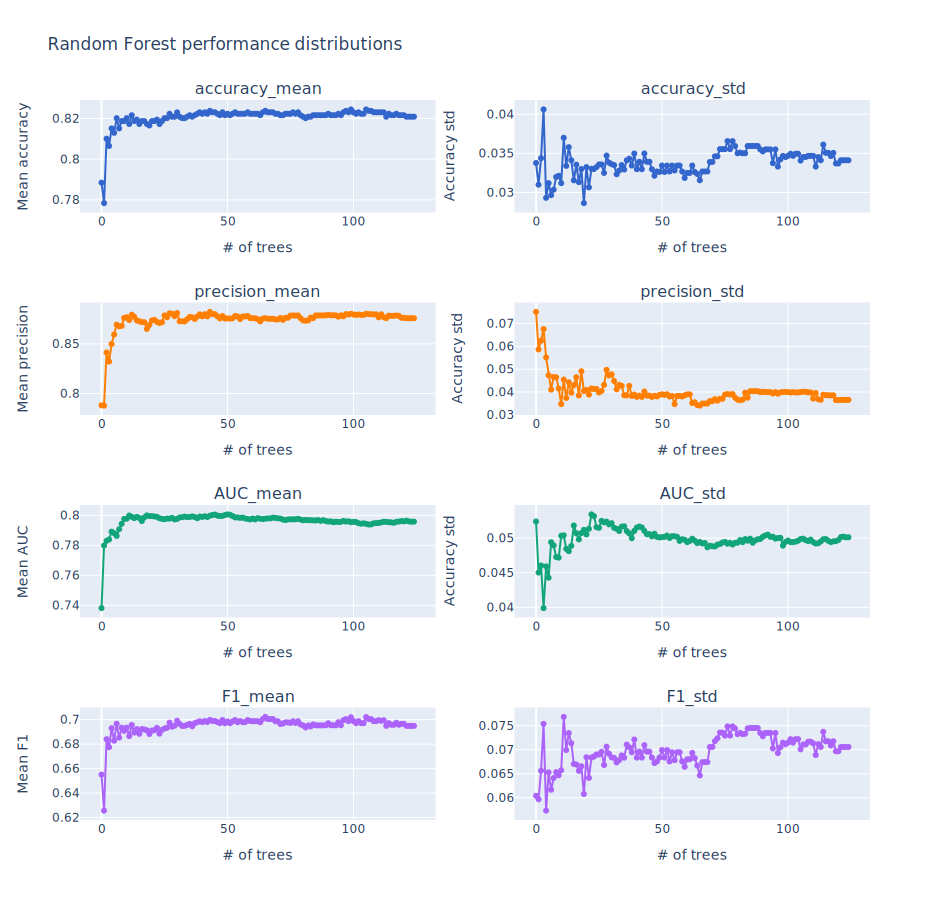

In [57]:
# Plot binary features
fig = make_subplots(
    rows=4,
    cols=2,
    subplot_titles=(
        "accuracy_mean",
        "accuracy_std",
        "precision_mean",
        "precision_std",
        "AUC_mean",
        "AUC_std",
        "F1_mean",
        "F1_std",
    ),
    shared_yaxes=False,
    shared_xaxes=False,
)

# Populate col1 subplots
fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.mean_test_accuracy,
        mode="lines+markers",
        name="accuracy",
        yaxis="y",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#3366CC"),
        marker=dict(color="#3366CC"),
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.mean_test_precision,
        mode="lines+markers",
        name="precision",
        yaxis="y",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#FF7F03"),
        marker=dict(color="#FF7F03"),
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.mean_test_AUC,
        mode="lines+markers",
        name="AUC",
        yaxis="y",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#12a579"),
        marker=dict(color="#12a579"),
    ),
    row=3,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.mean_test_F1,
        mode="lines+markers",
        name="F1",
        yaxis="y",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#AB63FA"),
        marker=dict(color="#AB63FA"),
    ),
    row=4,
    col=1,
)

# Populate col2 subplots
fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.std_test_accuracy,
        mode="lines+markers",
        name="accuracy",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#3366CC"),
        marker=dict(color="#3366CC"),
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.std_test_precision,
        mode="lines+markers",
        name="precision",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#FF7F03"),
        marker=dict(color="#FF7F03"),
    ),
    row=2,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.std_test_AUC,
        mode="lines+markers",
        name="AUC",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#12a579"),
        marker=dict(color="#12a579"),
    ),
    row=3,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=grid_search_results.index,
        y=grid_search_results.std_test_F1,
        mode="lines+markers",
        name="F1",
        hovertemplate="%{y:.3f}, %{x} trees",
        line=dict(color="#AB63FA"),
        marker=dict(color="#AB63FA"),
    ),
    row=4,
    col=2,
)


# Update xaxes
fig.update_xaxes(title_text="# of trees", row=1, col=1)
fig.update_xaxes(title_text="# of trees", row=2, col=1)
fig.update_xaxes(title_text="# of trees", row=3, col=1)
fig.update_xaxes(title_text="# of trees", row=4, col=1)
fig.update_xaxes(title_text="# of trees", row=1, col=2)
fig.update_xaxes(title_text="# of trees", row=2, col=2)
fig.update_xaxes(title_text="# of trees", row=3, col=2)
fig.update_xaxes(title_text="# of trees", row=4, col=2)


# Update yaxes
fig.update_yaxes(title_text="Mean accuracy", row=1, col=1)
fig.update_yaxes(title_text="Mean precision", row=2, col=1)
fig.update_yaxes(title_text="Mean AUC", row=3, col=1)
fig.update_yaxes(title_text="Mean F1", row=4, col=1)
fig.update_yaxes(title_text="Accuracy std",  row=1, col=2)
fig.update_yaxes(title_text="Accuracy std",row=2, col=2)
fig.update_yaxes(title_text="Accuracy std", row=3, col=2)


# Update title and height
fig.update_layout(
    title_text="Random Forest performance distributions", height=900,width=950, showlegend=False,yaxis=dict(autorange=True)
)

fig.show('svg')

For each of the graphs in this figure, we can see that the metric performance usually stabilizes after roughly 30 trees, depending on the randomization of our data and splits. For F1 score and precision there are some fluctuations in standard deviation above 40 trees, which means that our predictive outcomes are a little more consistent with higher numbers of decision trees in the model, but not by alot. These models are marginally more effective at certain numbers of trees, but for the most part, we can expect accuracy to be around 82-83%, and precision is pretty reliably around 90% for most values of n trees. Since we don't have much benefit to going to 100 trees in our tuned_rf model specification, we should just use the number of trees that maximizes accuracy and consider that our best random forest model on this data. 

I'll re-fit this model here with our number of estimators so that we have the performance metrics saved for comparison later. Then we'll look at a stacked model. 

In [47]:
# Update tuned model specification to include number of trees as a hyperparameter
tuned_rf = RandomForestClassifier(
    criterion=rf_best_params["criterion"],
    max_depth=rf_best_params["max_depth"],
    max_features=rf_best_params["max_features"],
    random_state=1,
    n_estimators=n_trees
)

rf_v3 = tuned_rf

# Resplit data
x_train, x_test, y_train, y_test = resplit_data(X, Y)

# Fit model
rf_v3.fit(x_train, y_train)

# Calculate statistics
rfv3_train = calculate_v2_model_training_stats(rf_v3, x_train, y_train)
rfv3_test = calculate_v2_model_testing_stats(rf_v3, x_test, y_test)

# Create new dt performance metrics df
rf_performance_metrics = assemble_performance_metrics_df(
    rf_cv, rfv3_train, rfv3_test
)
rf_performance_metrics

,v1: cross_val,v2: training,v2: testing
accuracy,0.826,0.863,0.819
precision,0.877,0.958,0.878
recall,0.595,0.644,0.573
f1,0.705,0.770,0.693


### Stacking (Stacked generalization)

In this section we'll look at stacking, which will involve use combining multiple classifier models before running them through another classifier, in the hopes that our tuned models from before will counteract each others' weaknesses to give us a more reliable prediction. Before we do any more ensemble modeling, let's re-partition our data using a higher test set proportion and a different random_state in order to hopefully counterbalance against the risk of overfitting in our stacking model

In [51]:
x_train, x_test, y_train, y_test = resplit_data(X,Y,test_size=0.4)

# Create classifiers from grid search parameters.
clf1 = tuned_knn

clf2 = tuned_dt

clf3 = tuned_NB

For this stacking classifier we'll create the classifiers based on the parameters set by grid search so that we can compare them to their previous counterparts on equal footing. 

In [52]:
# Initialize and fit the stacking classifier
sclf = StackingClassifier(
    classifiers=[clf1, clf2, clf3], meta_classifier=LogisticRegression()
)
sclf.fit(x_train, y_train)

# Assemble test and training set data
sclf_performance_metrics = pd.concat(
    [
        calculate_v2_model_training_stats(sclf, x_train, y_train),
        calculate_v2_model_testing_stats(sclf, x_test.values, y_test.values),
    ],
    axis=1,
)
sclf_performance_metrics

,v2: training,v2: testing
accuracy,0.835,0.834
precision,0.932,0.932
recall,0.580,0.577
f1,0.715,0.713


This stacked model is predicting at a similar level to our random forest above without being as computationally intensive, despite the three classifiers being used being individually weaker models--not bad. But as a final pass at model creation , let's create a voting classifier that groups together our knn, logistic regression, and random forest classifiers. We'll use the tuned model specifications for each from earlier to see if our ~83%ish accuracy really is the upper limit for this dataset. 

### Voting Classifier Modeling

In [53]:
# Resplit
x_train, x_test, y_train, y_test = resplit_data(X, Y)

# Initialize models
clf1 = tuned_knn
clf2 = tuned_logistic_model
clf3 = tuned_rf
estimators = [("knn", clf1), ("lr", clf2), ("rf", clf3)]

#fit voting classifier
vc = VotingClassifier(estimators=estimators, voting="soft")
vc.fit(x_train,y_train)

# Calculate model performance across both subsets of the data
vc_performance_metrics = pd.concat(
    [
        calculate_v2_model_training_stats(vc, x_train, y_train),
        calculate_v2_model_testing_stats(vc, x_test, y_test),
    ],
    axis=1,
)
vc_performance_metrics

,v2: training,v2: testing
accuracy,0.837,0.802
precision,0.909,0.868
recall,0.604,0.526
f1,0.726,0.655


Here we can see that this model is perfoming similarly to the other ensemble models, with some slight overfitting perhaps. Let's take a look at our ensemble model performance across the the random forest model, stacked classifier model, and voting classifier to see if these 3 options are truly interchangeable. Before we dive into takeaways and solutions. 

In [54]:
compare_models(single_models_df,rf_performance_metrics,sclf_performance_metrics,vc_performance_metrics)

,logistic_regression,k_nearest_neighbors,decision_tree,naive_bayes,random_forest,stacked_classifier,voting_classifier
accuracy,0.782,0.771,0.841,0.763,0.863,0.835,0.837
precision,0.813,0.820,0.918,0.774,0.958,0.932,0.909
recall,0.507,0.459,0.610,0.475,0.644,0.580,0.604
f1,0.625,0.588,0.733,0.589,0.770,0.715,0.726


# Conclusions

The table above shows that we have boosted our stats about as high as they'll go. So let's take stock of what we have so far. We've been using accuracy, followed by precision as our main measurements of effectiveness while building models here, but before we give our final model to the airline we should make sure that it's aligned to their consumer marketing/targeting needs. 


 <ins>Accuracy</ins> 
- A high-accuracy model would be better if the airline is planning on simultaneously launching packages targeting both experienced and new travelers. Experienced travelers want luxury or exclusive packages possibly linked to their loyalty programs or miles, while newer travelers want deals and amenities. This style of model is good when we want to make sure that both classes of customers are being pitched the right products at the right time. 

 <ins>Precision</ins> 
- A high-precision model would be better at predicting which customers buy travel insurance, which will also be helpful for marketing new-traveler/new airline customer deals for the proportion of customers we identified that are taking their first trips. 

 <ins>Recall</ins> 
- A high-recall model would be better if we were worried that improperly targeted customers would consider the marketing a nuisance or a negative impact to their relationship with the airline's brand.

 <ins>F1-score</ins> 
- A high-F1-score model would be perfect if we want to balance precision and recall. This model type would be better for all-purpose use since the costs of improper targeting or occasional mislabeling might not be that high for the airline, based on their ongoing marketing strategy. 

Considering that our firm has been contracted by the airline, but we aren't a part of their marketing strategy and product development, we should use an all-around model specification. Lucky for us our random forest model is a strong performer across all of our metrics, and also boasts a pretty solid recall rate. Selecting based on F1 would lead us to this score, and it is thankfully one of our most consistent models in terms of accuracy. We'll submit our final recommendations to the client using our final tuned random forest model. 

## Further Research ideas

For ongoing research, we could use new data to either maintain or update our random forest classifier. To do this we would need: 
- Data from the v1 rollout of their new product(s)/consumer marketing

- Newer data from the market so that we could test this model's extensibility to age groups or demographics outside of this training set

- Temporal data to consider seasonality and price fluctuation impacts to our predictions 

- Price data more generally

- Longitudinal data about customer conversion: Do patients targeted with our model/these products subscribe to loyalty programs, provide any feedback, or fly with the airline again? Customer churn could inform how we go about model selection in our accuracy, precision, recall, F1 matrix